In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import torch

# knn tree
from scipy.spatial import KDTree



In [73]:
class cell:
    def __init__(self, x, y, r):
        self.x = torch.tensor(x).float()
        self.y = torch.tensor(y).float()
        self.angle = torch.tensor(np.random.rand()*360).float()
        # self.r = torch.tensor(r).float()


    def as_inp(self, other_cell):
        angles_diff = other_cell.angle - self.angle
        acute_angle = min(angles_diff, 360 - angles_diff)

        angle_to_other = torch.arctan2(other_cell.y - self.y, other_cell.x - self.x)
        angle_diff = angle_to_other - self.angle
        acute_diff = min(angle_diff, 360 - angle_diff)

        sqrdist = ((other_cell.x - self.x)**2 + (other_cell.y - self.y)**2 )

        return [sqrdist, angle_to_other, acute_diff, acute_angle, ]

        # return [self.x, self.y, self.z, self.angle, self.r]


class brain:
    def __init__(self, n_hidden_layers, n_cells):
        self.n_cells = n_cells
        self.n_hidden_layers = n_hidden_layers

        self.cells = self.create_cells()
        self.hidden_layers = self.create_hidden_layers()

        self.optimizer = torch.optim.Adam(self.hidden_layers.parameters(), lr=0.01)

    def create_cells(self):
        cells = []
        for i in range(self.n_cells):
            x = np.random.rand()*4. - 2.
            y = np.random.rand()*4. - 2.
            r = np.random.rand()
            cells.append(cell(x, y, r))

        return cells
    
    def create_hidden_layers(self):
        # 3 input layer
        inp = torch.nn.Linear(4, 10)

        # hidden layers with 10 neurons each and tanh activation function
        hidden_layers = []
        for i in range(self.n_hidden_layers):
            hidden_layers.append(torch.nn.Linear(10, 10))
            hidden_layers.append(torch.nn.Tanh())
            
        # output layer with activation function
        # move y, move y,  
        out = torch.nn.Linear(10, 4)

        out_act = torch.nn.Tanh()        
        


        return torch.nn.Sequential(inp, *hidden_layers, out, out_act)

    def get_nbs(self):
        # get 7 knn
        points = []
        for cell in self.cells:
            points.append([cell.x.detach().numpy(), cell.y.detach().numpy()])
        
        tree = KDTree(points)
        _, indices = tree.query(points, k=7)

        return indices
    
    def forward(self, x):
        return self.hidden_layers(x)
    

    def loss(self, x, y):
        return torch.nn.MSELoss()(x, y)
    
    def move_cell(self, cell, out):
        outnp = out#.detach().numpy()
        cell.x += outnp[0] 
        cell.y += outnp[1]
        cell.angle += torch.arctan2(outnp[3], outnp[2])


    
    def step(self):
        nbs = self.get_nbs()
        loss = 0.

        # find center of the cluster
        center = torch.tensor([0., 0.])
        for cell in self.cells:
            center += torch.tensor([cell.x, cell.y])
        center /= self.n_cells
        

        for i in range(self.n_cells):
            for j in nbs[i]:
                if i == j:
                    continue
                c = self.cells[i]
                inp = c.as_inp(self.cells[j])
                inp = torch.tensor(inp).float()
                out = self.forward(inp)


                # move cell according to output
                self.move_cell(c, out)
                
                # calculate loss
                # find distance to center
                dist = torch.tensor([torch.sqrt((c.x - center[0])**2 + (c.y - center[1])**2)]).float()



                loss += self.loss(dist, torch.tensor([0.]).float())




        return loss
    
    
    

    def train(self, n_steps):
        for i in range(n_steps):
            loss = self.step()

            # backpropagate
            loss.requires_grad = True
            loss.backward()

            # update weights
            self.optimizer.step()
            self.optimizer.zero_grad()

            if i % 100 == 0:
                print(i/n_steps*100, loss.item())
                self.cells = self.create_cells()


    def plot_cells(self):
        for cell in self.cells:
            x = cell.x.detach().numpy()
            y = cell.y.detach().numpy()
            angle = cell.angle.detach().numpy()
            plt.plot(x, y, 'o')
            plt.quiver(x, y, np.cos(angle), np.sin(angle))
        plt.show()


b = brain(6, 10)
b.train(5000)


0.0 204.44680786132812
2.0 398.925048828125
4.0 1064.8287353515625
6.0 332.1274719238281
8.0 247.4150390625
10.0 312.2492370605469
12.0 422.165771484375
14.000000000000002 304.8214416503906
16.0 305.44378662109375
18.0 354.06329345703125
20.0 281.27215576171875
22.0 695.8905639648438
24.0 724.931396484375
26.0 659.2552490234375
28.000000000000004 301.0459899902344
30.0 212.72061157226562
32.0 782.3068237304688
34.0 244.35818481445312
36.0 501.13720703125
38.0 266.8372497558594
40.0 325.8175354003906
42.0 511.67181396484375
44.0 569.3897705078125
46.0 300.7383117675781
48.0 702.3807983398438
50.0 582.0758666992188
52.0 700.2557373046875
54.0 219.62889099121094
56.00000000000001 932.2981567382812
57.99999999999999 198.43507385253906
60.0 384.06365966796875
62.0 456.9302062988281
64.0 570.3633422851562
66.0 894.644775390625
68.0 502.2525329589844
70.0 534.6195068359375
72.0 461.0885925292969
74.0 399.1392517089844
76.0 718.4678955078125
78.0 259.1102294921875
80.0 792.7108764648438
82.0 7

In [74]:
b.cells = b.create_cells()


In [75]:
for i in range(100):
    avg_dist = 0
    center = torch.tensor([0., 0.])
    for cell in b.cells:
        center += torch.tensor([cell.x, cell.y])
    center /= b.n_cells
    
    center = center.detach().numpy()
    for cell in b.cells:
        avg_dist += np.linalg.norm(np.array([cell.x.detach().numpy(), cell.y.detach().numpy()]) - center)
    avg_dist /= b.n_cells

    print(avg_dist)
    b.step()

1.1145641563460231
1.1063931873533874
1.1029166467487812
1.09992759488523
1.097129612416029
1.093487375974655
1.0898892283439636
1.085068941116333
1.0794537156820296
1.0737012878060341
1.0676328107714652
1.061351428925991
1.0550193518400193
1.0486304819583894
1.0423978865146637
1.0350503981113435
1.0276081562042236
1.0205238997936248
1.0134448796510696
1.006678545475006
1.0005252808332443
0.995161497592926
0.990569868683815
0.986709475517273
0.9832625716924668
0.9801917344331741
0.9773212045431137
0.9749014258384705
0.9727654308080673
0.9709168523550034
0.9693450927734375
0.9680341005325317
0.9669534504413605
0.9660856753587723
0.965395987033844
0.964757639169693
0.9642163872718811
0.9637404352426528
0.9633674860000611
0.9629851251840591
0.9625070720911026
0.9619955897331238
0.9614525258541107
0.9608886480331421
0.960258424282074
0.9596061944961548
0.9589502930641174
0.9582947939634323
0.9577466130256653
0.9572100669145585
0.9566885828971863
0.9562034636735917
0.9557404011487961
0.9552

In [16]:
b.step()

tensor(123.0210, grad_fn=<AddBackward0>)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

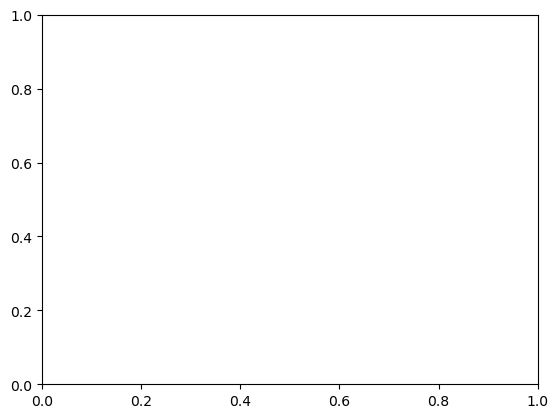

In [54]:
b.plot_cells()
